<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Preprocessing on Sleep Disorder Prediction</p>

In [466]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import statsmodels.api as sm


# import others
import os
import pickle

#### Import data

In [286]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


#### Split in to train and test

In [291]:
X = df[settings.ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)

In [292]:
# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)
# check new values in consolidated column
display(settings.examine_values(y_train).loc["Sleep Disorder",:])
display(settings.examine_values(y_train).loc["Sleep Disorder",:])

Unique Values    [1, 0, 2]
Name: Sleep Disorder, dtype: object

Unique Values    [1, 0, 2]
Name: Sleep Disorder, dtype: object

*Reshape y to be 1-D vector*

In [293]:
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Multinomial Regression</p>

*Preprocess steps*

In [346]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
        ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough')

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, column_trans.fit_transform(X_train))
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, column_trans.transform(X_test))

display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

'train: check for dummy encoded columns and scaled values (mean 0 and std 1)'

(299, 23)

,Gender_Female,Gender_Male,Occupation_Accountant,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Nurse,Occupation_Salesperson,Occupation_Teacher,Occupation_Unknown,BMI Category_Normal,BMI Category_Overweight,Blood Pressure Category_Elevated,Blood Pressure Category_High Blood Pressure Stage 1,Blood Pressure Category_High Blood Pressure Stage 2,Blood Pressure Category_Normal,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
mean,0.491639,0.508361,0.113712,0.187291,0.163880,0.133779,0.193980,0.080268,0.093645,0.033445,0.585284,0.414716,0.32107,0.367893,0.197324,0.113712,-1.837995e-16,3.017839e-16,2.710578e-16,8.273297e-17,-2.361545e-16,1.145126e-15,9.992936e-17
std,0.500768,0.500768,0.317994,0.390799,0.370787,0.340986,0.396076,0.272162,0.291823,0.180096,0.493499,0.493499,0.46767,0.483040,0.398646,0.317994,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00


'test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)'

(75, 23)

,Gender_Female,Gender_Male,Occupation_Accountant,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Nurse,Occupation_Salesperson,Occupation_Teacher,Occupation_Unknown,BMI Category_Normal,BMI Category_Overweight,Blood Pressure Category_Elevated,Blood Pressure Category_High Blood Pressure Stage 1,Blood Pressure Category_High Blood Pressure Stage 2,Blood Pressure Category_Normal,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
mean,0.506667,0.493333,0.040000,0.200000,0.186667,0.093333,0.200000,0.106667,0.160000,0.013333,0.546667,0.453333,0.360000,0.360000,0.186667,0.093333,0.126738,0.143172,0.076646,0.019312,-0.101722,-0.131451,-0.053973
std,0.503322,0.503322,0.197279,0.402694,0.392268,0.292858,0.402694,0.310768,0.369075,0.115470,0.501170,0.501170,0.483232,0.483232,0.392268,0.292858,1.050244,1.018893,0.963742,0.990402,0.970543,0.858403,0.872333


*Create pipeline and base model*

In [468]:
# create model
model_mlr = LogisticRegression(multi_class='multinomial', max_iter=1000) # using default solver "lgbgs" and penalty "l2"

# Create a pipeline with the column transformer
steps_mlr = [
        ("preprocess", column_trans), 
        ("multinomial_logistic_regression", model_mlr)
        ]
pipeline_mlr = Pipeline(steps_mlr)

# create cross validation object for validation step
cv_mlr = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring='accuracy', cv=cv_mlr, n_jobs=-1)
display('Mean Train Accuracy across 5 folds: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

display(f'Test Accuracy:{pipeline.score(X_test, y_test)}')

'Mean Train Accuracy across 5 folds: 0.903 (0.029)'

'Test Accuracy:0.92'

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>High baseline model train cv accuracy ~ 90% and test ~92%</li>
</ul>
</div>


In [473]:
model_mlr.fit(transformed_X_train_df, y_train)

# Save as best model
try:
    with open('best_multinomial_logistic_regression_model.pkl', 'rb') as model_file:
        best_model = pickle.load(model_file)
except FileNotFoundError:
    # Create and save a baseline model
    # Replace this with code to create your baseline model
    with open('best_model.pkl', 'wb') as model_file:
        pickle.dump(model_mlr, model_file)

*Hyperparam tuning*

*Regularisation*

In [400]:
# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__penalty': ['l2', "none"] # l1 not typically used for multinomial due to compuataional and interpretibility challenges
}

# Create and fit GridSearchCV object on training data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring='accuracy', cv=cv_mlr, n_jobs=-1)
grid_search_mlr.fit(X_train, y_train)

# Access the best hyperparameters and results
best_params, best_score = grid_search_mlr.best_params_, grid_search_mlr.best_score_

# See how long convergence took on best model
print("Iterations to convergence:", best_model['multinomial_logistic_regression'].n_iter_[0])

# Print the best parameters
print("\nBest Parameters:") 
display(pd.DataFrame(best_params, index=[0]))

# Print the best training score
print("Train Accuracy with best parameters:", np.round(best_score, 6)*100, "%")

# Evaluate the best model on the test set
best_model = grid_search_mlr.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy with best parameters:", np.round(test_accuracy, 6)*100, "%")

Iterations to convergence: 131

Best Parameters:


,multinomial_logistic_regression__penalty
0,l2


Train Accuracy with best parameters: 90.3013 %
Test Accuracy with best parameters: 92.0 %


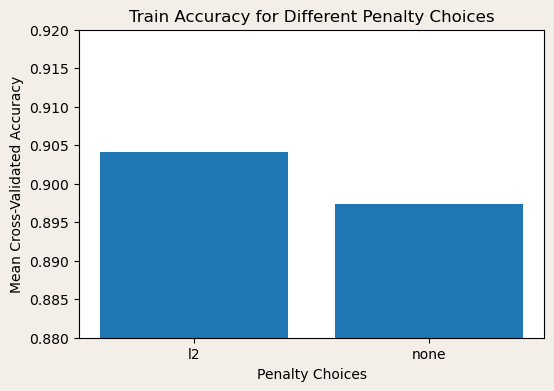

In [458]:
# Access the grid search results
results = grid_search_mlr.cv_results_

# Extract C values and accuracy scores
penalty_values = results['param_multinomial_logistic_regression__penalty'].data
mean_test_scores = results['mean_test_score']

fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")

# Plot the accuracy scores as C varies using the ax object
ax.bar(penalty_values, mean_test_scores)

# Calculate the range for y-axis to show small differences
y_min, y_max = 0.88, 0.92
ax.set_ylim(y_min, y_max)  # Set the y-axis limits using ax.set_ylim

ax.set_xlabel('Penalty Choices')
ax.set_ylabel('Mean Cross-Validated Accuracy')
ax.set_title('Train Accuracy for Different Penalty Choices')

plt.show()


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Regularisation providing slightly higher score compared to none. Both will be tested with further tuning</li>
</ul>
</div>


In [420]:
# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__C': [0.001, 0.01, 0.1, 1, 10, 100], # default = 1 (moderate)
    'multinomial_logistic_regression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], # default = lbfgs 
    'multinomial_logistic_regression__penalty': ['l2', "none"] # default = l2
}

# Create and fit GridSearchCV object on training data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring='accuracy', cv=cv_mlr, n_jobs=-1)
grid_search_mlr.fit(X_train, y_train)

# Access the best hyperparameters and results
best_params, best_score = grid_search_mlr.best_params_, grid_search_mlr.best_score_

# See how long convergence took on best model
print("Iterations to convergence:", best_model['multinomial_logistic_regression'].n_iter_[0])

# Print the best parameters
print("\nBest Parameters:") 
display(pd.DataFrame(best_params, index=[0]))

# Print the best training score
print("Train Accuracy with best parameters:", np.round(best_score, 6)*100, "%")

# Evaluate the best model on the test set
best_model = grid_search_mlr.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy with best parameters:", np.round(test_accuracy, 6)*100, "%")

Iterations to convergence: 131

Best Parameters:


,multinomial_logistic_regression__C,multinomial_logistic_regression__penalty,multinomial_logistic_regression__solver
0,10,l2,newton-cg


Train Accuracy with best parameters: 90.4124 %
Test Accuracy with best parameters: 94.6667 %


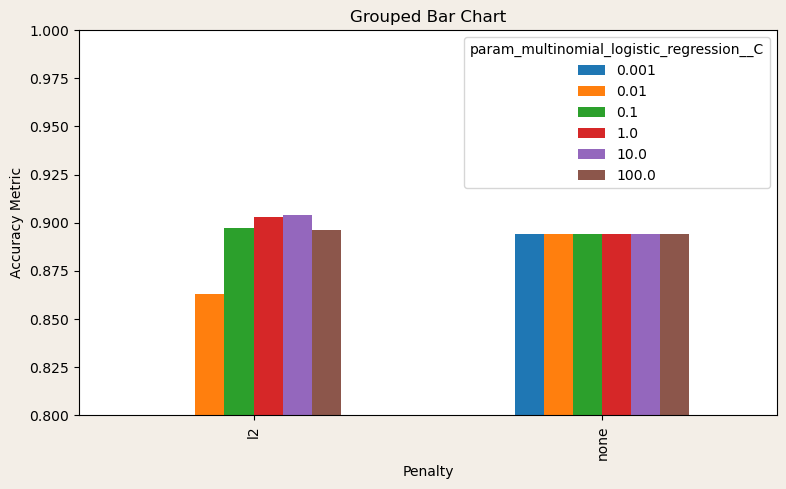

In [465]:
# Access the latest grid search results
results = grid_search_mlr.cv_results_

# Extract penalty, C values and accuracy scores
grouped = pd.DataFrame(results).groupby(["param_multinomial_logistic_regression__penalty","param_multinomial_logistic_regression__C"])["mean_test_score"].mean().unstack()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")

# Plot the grouped bar chart using the ax object
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Set y-axis limits
y_min, y_max = 0.8, 1
ax.set_ylim(y_min, y_max)  # Set the y-axis limits

ax.set_xlabel('Penalty')
ax.set_ylabel('Accuracy Metric')
ax.set_title('Grouped Bar Chart')

plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Regularisation providing higher scores compared to none only for specific strengths (C). This is the case for noteably for 10</li>
</ul>
</div>


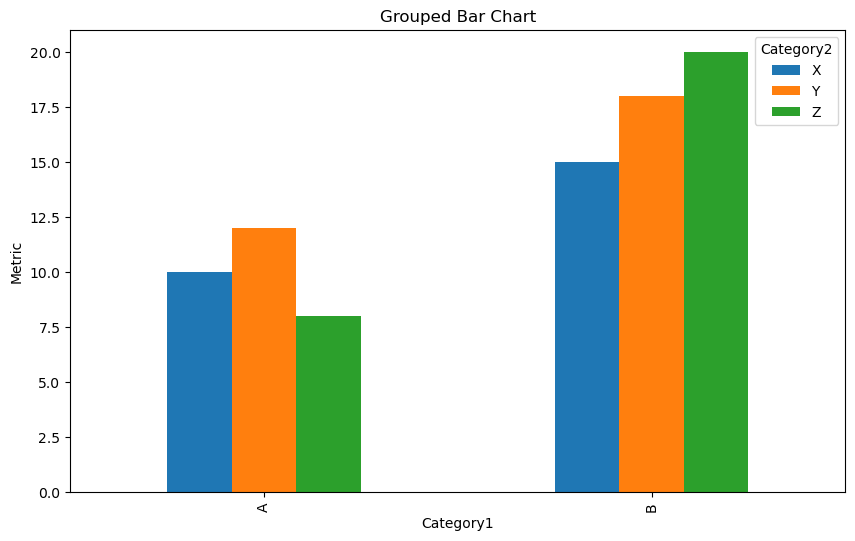

In [431]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame
data = {
    'Category1': ['A', 'B', 'A', 'B', 'A', 'B'],
    'Category2': ['X', 'X', 'Y', 'Y', 'Z', 'Z'],
    'Metric': [10, 15, 12, 18, 8, 20]
}

df = pd.DataFrame(data)

# Group data by Category1 and Category2 and calculate mean for Metric
grouped_data = df.groupby(['Category1', 'Category2'])['Metric'].mean().unstack()

# Plotting the grouped bar chart
ax = grouped_data.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Category1')
plt.ylabel('Metric')
plt.title('Grouped Bar Chart')

plt.legend(title='Category2')

plt.show()


In [249]:
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

model_mr.fit(X_train, y_train)
print("Iterations to convergence:", model_mr.n_iter_)
y_pred = model_mr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Print the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Mean Train Accuracy across 5 folds: 0.902 (0.029)
Iterations to convergence: [56]
Test Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       0.87      0.81      0.84        16
           2       0.88      0.93      0.90        15

    accuracy                           0.92        75
   macro avg       0.90      0.90      0.90        75
weighted avg       0.92      0.92      0.92        75



In [250]:
class_labels = ["None","Apnea","Insomnia"]
features = X_train.columns

# Accessing the coefficients
coefficients = model_mr.coef_

# Print the coefficients for each class
print("Coefficients for each class:")
for i in range(len(class_labels)):
    for feature in features:
        print(feature)


Coefficients for each class:
Gender
Age
Sleep Duration
Quality of Sleep
Physical Activity Level
Stress Level
BMI Category
Heart Rate
Daily Steps
Blood Pressure Category_High Blood Pressure Stage 1
Blood Pressure Category_High Blood Pressure Stage 2
Blood Pressure Category_Normal
Occupation_Doctor
Occupation_Engineer
Occupation_Lawyer
Occupation_Nurse
Occupation_Salesperson
Occupation_Teacher
Occupation_Unknown
Gender
Age
Sleep Duration
Quality of Sleep
Physical Activity Level
Stress Level
BMI Category
Heart Rate
Daily Steps
Blood Pressure Category_High Blood Pressure Stage 1
Blood Pressure Category_High Blood Pressure Stage 2
Blood Pressure Category_Normal
Occupation_Doctor
Occupation_Engineer
Occupation_Lawyer
Occupation_Nurse
Occupation_Salesperson
Occupation_Teacher
Occupation_Unknown
Gender
Age
Sleep Duration
Quality of Sleep
Physical Activity Level
Stress Level
BMI Category
Heart Rate
Daily Steps
Blood Pressure Category_High Blood Pressure Stage 1
Blood Pressure Category_High Bloo

In [251]:
class_labels = ["None","Apnea","Insomnia"]
features = X_train.columns
for i, class_label in enumerate(class_labels):
    print("Class:", class_label)
    print("")
    print("Feature:", 44*" ", "Log Odds Weight", 10*" ", "Odds Weight")
    print("--------", 44*" ", "---------------", 10*" ", "-----------")
    for ii, feature in enumerate(features):
        print(feature, (52-len(feature))*" ", np.round(model_mr.coef_[i][ii],5), 18*" ",np.round(np.exp(model_mr.coef_[i][ii]),5))


Class: None

Feature:                                              Log Odds Weight            Odds Weight
--------                                              ---------------            -----------
Gender                                                0.15873                    1.17202
Age                                                   -0.66051                    0.51659
Sleep Duration                                        0.10233                    1.10774
Quality of Sleep                                      0.29041                    1.33698
Physical Activity Level                               0.23564                    1.26571
Stress Level                                          0.05644                    1.05807
BMI Category                                          -0.64098                    0.52677
Heart Rate                                            -0.61177                    0.54239
Daily Steps                                           -0.02098                    0.97

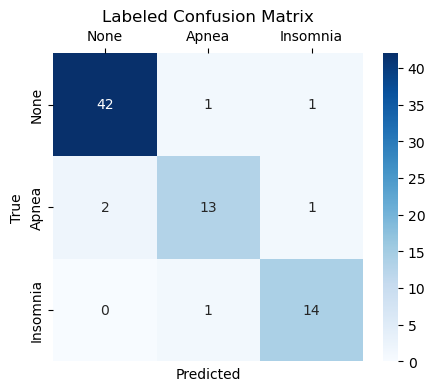

In [252]:
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Labeled Confusion Matrix")
plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels
plt.gca().xaxis.tick_top()  # Move x-axis ticks to the top
plt.show()


<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Decision Tree</p>

<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Random Forest</p>